In [2]:
# test if we can import vit-prisma

import numpy as np
import torch
from torch.utils.data import DataLoader
from vit_prisma.utils.constants import (
    DEVICE,
)
from vit_prisma.utils.tutorial_utils import (
    get_feature_activations,
    plot_act_distribution,
    plot_image,
)


In [3]:
import sys
from pathlib import Path

try:
    _project_root = Path(__file__).resolve().parents[1]
except NameError:
    _project_root = Path.cwd().parent

if str(_project_root) not in sys.path:
    sys.path.append(str(_project_root))


In [4]:
log_dir = "/nfs/turbo/coe-chaijy/janeding/regrounding/results_log"


In [5]:
import gc

# clear cache
torch.cuda.empty_cache()
# force garbage collection
gc.collect()

torch.cuda.set_device(0)
DEVICE = torch.device("cuda:0")


# Step 1: Load Transcoder and CLIP

In [ ]:
# Load all transcoders
from src.analysis.utils import *

tc_list = load_all_tc()


2025-07-24 00:57:45 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443


2025-07-24 00:57:45 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/resolve/main/weights.pt HTTP/1.1" 302 0
2025-07-24 00:57:45 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/resolve/main/config.json HTTP/1.1" 307 0
2025-07-24 00:57:45 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/b9ff9647261516e5c7a882f7fd130db702c8ea25/config.json HTTP/1.1" 200 0


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/snapshots/b9ff9647261516e5c7a882f7fd130db702c8ea25/weights.pt...


2025-07-24 00:57:47 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 768}
2025-07-24 00:57:47 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/resolve/main/weights.pt HTTP/1.1" 302 0
2025-07-24 00:57:47 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/resolve/main/config.json HTTP/1.1" 307 0
2025-07-24 00:57:47 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/96c293a7299a99fe3d70f1f15498215849f22d96/config.json HTTP/1.1" 200 0


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/snapshots/96c293a7299a99fe3d70f1f15498215849f22d96/weights.pt...


2025-07-24 00:57:48 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 256}
2025-07-24 00:57:48 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/resolve/main/weights.pt HTTP/1.1" 302 0


In [ ]:
# we will first start by the last transcoder
from pprint import pprint

tc_10 = tc_list[10]
pprint(tc_10.cfg)
tc_10.cfg.hook_point


VisionModelSAERunnerConfig(model_class_name='HookedViT',
                           model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                           vit_model_cfg=None,
                           model_path=None,
                           hook_point_layer=10,
                           layer_subtype='ln2.hook_normalized',
                           hook_point_head_index=None,
                           context_size=50,
                           use_cached_activations=False,
                           use_patches_only=False,
                           cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized',
                           image_size=224,
                           architecture='standard',
                           b_dec_init_method='geometric_median',
                           expansion_factor=64,
                           f

'blocks.10.ln2.hook_normalized'

In [ ]:
# DEVICE = 'cuda:0'


# load text model
def name_from_hf(model_name):
    """return model name from huggingface"""
    return model_name.replace("open-clip:", "hf-hub:")


import open_clip

# model_name = name_from_hf(tc_10.cfg.model_name)
# print(model_name)
model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    model_name
)
model.to(DEVICE)
model.eval()

tokenizer = open_clip.get_tokenizer(model_name)
print(tokenizer)

print(preprocess_val)


In [ ]:
# load vision model
from vit_prisma.models.model_loader import load_hooked_model
from vit_prisma.utils.enums import ModelType

model_name = tc_10.cfg.model_name
print(model_name)

model_v = load_hooked_model(model_name, model_type=ModelType.VISION)
model_v.to(DEVICE)


open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K


HookedViT(
  (embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  )
  (hook_embed): HookPoint()
  (pos_embed): PosEmbedding()
  (hook_pos_embed): HookPoint()
  (hook_full_embed): HookPoint()
  (ln_pre): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (hook_ln_pre): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): Ho

# Step 2: Load image and labels

WARNING	Task(Task-2) matplotlib.image:image.py:_normalize_image_array()- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


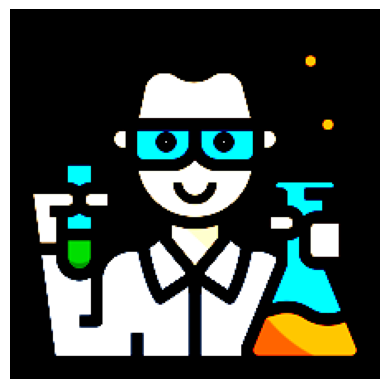

In [ ]:
# load image
from PIL import Image
from vit_prisma.transforms import get_clip_val_transforms

# img_path = '/nfs/turbo/coe-chaijy/janeding/example_images/smiling-face.png'
img_path = (
    "/nfs/turbo/coe-chaijy/janeding/regrounding/example_images/biochemist.png"
)
gt_label = "chemist"
img = Image.open(img_path).convert()  # Ensure it's 3 channels
transforms = get_clip_val_transforms()
img_tensor = transforms(img)
plot_image(img_tensor.detach().cpu(), unstandardise=False)


In [ ]:
# see how clip will classify the image

# load labels
import ast
from typing import List


# load imagenet 1000 labels
def load_labels_txt(file_path="imagenet-1000.txt") -> List:
    """
    load imagenet 1000 labels and return a list of labels
    """
    with open(file_path, encoding="utf-8") as f:
        content = f.read()

    # parse dict
    labels_dict = ast.literal_eval(content)

    # convert to list, sorted by index
    labels_list = [labels_dict[i] for i in range(len(labels_dict))]

    return labels_list


def load_words_from_txt(file_path):
    """return a list of words from a txt file"""
    with open(file_path, encoding="utf-8") as f:
        words = [line.strip() for line in f]

    return words


def load_labels_csv(file_path="concreteness_rating.csv") -> List:
    """
    load concreteness rating labels and return a list of labels
    """
    import pandas as pd

    df = pd.read_csv(file_path)
    labels = df["Word"].tolist()
    labels = [
        str(label) for label in labels if pd.notna(label) and str(label).strip()
    ]
    return labels


def load_labels(file_path="concreteness_rating.csv", num_labels=-1) -> List:
    import random

    from src.extra_labels import EXTRA_LABELS

    if "20k" in file_path:
        labels = load_words_from_txt(file_path)
    elif file_path.endswith(".txt"):
        labels = load_labels_txt(file_path)
    elif file_path.endswith(".csv"):
        labels = load_labels_csv(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

    if num_labels > 0:
        labels = random.sample(labels, num_labels)
    # add extra labels
    labels.extend(EXTRA_LABELS)
    labels = list(set(labels))
    return labels


# load labels
file_path = "concreteness_rating.csv"
labels = load_labels(file_path=file_path)

# show first 10 labels
print(f"Labels loaded from: {file_path}")
print(f"Total {len(labels)} labels")
print("\nfirst 10 labels:")
for i, label in enumerate(labels[: min(10, len(labels))]):
    print(f"{i}: {label}")

print("\nlast 10 labels:")
for i, label in enumerate(
    labels[-min(10, len(labels)) :], len(labels) - min(10, len(labels))
):
    print(f"{i}: {label}")

# can also use list directly
print("\nLabels are ready, can be used for model input")
print(f"for example: labels[0] = '{labels[0]}'")


Labels loaded from: concreteness_rating.csv
Total 39957 labels

first 10 labels:
0: partisan
1: homebound
2: bogged down
3: pillager
4: vivaciousness
5: pornographically
6: burrower
7: reelect
8: involuntarily
9: bald

last 10 labels:
39947: jogger
39948: couch
39949: becoming
39950: dateline
39951: echogram
39952: codeine
39953: nauseate
39954: shorter
39955: setoff
39956: oceanic

Labels are ready, can be used for model input
for example: labels[0] = 'partisan'


In [ ]:
# clear cache
torch.cuda.empty_cache()
# force garbage collection
gc.collect()


1363

In [ ]:
CHUNK_SIZE = 512


prompts = [f"a photo of a {l}" for l in labels]
text_tokens = open_clip.tokenize(prompts)  # [N, 77] on CPU

with torch.no_grad():
    image_input = img_tensor.unsqueeze(0).to(DEVICE)
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_feats_out = []
    for i in range(0, len(text_tokens), CHUNK_SIZE):
        chunk = text_tokens[i : i + CHUNK_SIZE].to(DEVICE, non_blocking=True)
        feats = model.encode_text(chunk)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_feats_out.append(feats.cpu())
    text_features = torch.cat(text_feats_out).to(DEVICE)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_idx = text_probs.squeeze().topk(10)

for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
    print(f"{i+1}. label: {labels[idx]:<20} | prob: {prob.item():.4f}")


1. label: scientist            | prob: 0.2507
2. label: chemist              | prob: 0.1971
3. label: biochemist           | prob: 0.0807
4. label: toxicologist         | prob: 0.0429
5. label: experimentalist      | prob: 0.0401
6. label: nonscientist         | prob: 0.0309
7. label: pharmacologist       | prob: 0.0300
8. label: sexologist           | prob: 0.0182
9. label: cosmologist          | prob: 0.0166
10. label: geochemist           | prob: 0.0148


# Step 3: Find $f_{end}$
We will calculate the cos similarity for the label "chemistry"'s text embedding and the transcoder decoder matrix of the last layer, to get the most related feature, also our destination $f_{end}$.

In [ ]:
# get text embedding
# gt_label = 'chemistry'
# gt_label = 'smile'
text_input = tokenizer([gt_label]).to(DEVICE)
with torch.no_grad():
    text_embedding = model.encode_text(text_input)
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)

text_embedding.shape


torch.Size([1, 512])

In [ ]:
decoder_vectors = tc_10.W_dec.T
decoder_vectors = decoder_vectors / decoder_vectors.norm(dim=-1, keepdim=True)
decoder_vectors.shape


torch.Size([768, 49152])

In [ ]:
projected_decoder_vectors = model.visual.proj.T @ decoder_vectors
projected_decoder_vectors.shape


torch.Size([512, 49152])

In [ ]:
similarities = text_embedding @ projected_decoder_vectors
similarities


tensor([[-1.8606e-04, -1.5921e-03, -6.1627e-04,  ...,  8.6095e-05,
          1.4082e-03,  2.7063e-03]], device='cuda:0', grad_fn=<MmBackward0>)

In [ ]:
top_k_similarities, top_k_indices = torch.topk(similarities.squeeze(), k=1)
f_end_index = top_k_indices[0].item()
f_end_similarity = top_k_similarities[0].item()

print(
    f"in MLP layer, the most related visual feature (f_end) index is: {f_end_index}"
)
print(f"cosine similarity in shared space is: {f_end_similarity:.4f}")

feature_idx = f_end_index


in MLP layer, the most related visual feature (f_end) index is: 46014
cosine similarity in shared space is: 0.0107


# Step 4: Circuit analysis

In [ ]:
def run_with_cache(model_input, model):
    """Run the batch through the model to get activations"""
    _, cache = model.run_with_cache(model_input)
    return cache


def get_feature_activations(tc, cache):
    """Compute the activation given a cache. If cache is not provided, run the model with cache.
    we only need the activations of the hook point, so here use .encode() to get the activations instead of a forward pass.
    """
    # _, cache = model.run_with_cache(model_input, names_filter=tc.cfg.hook_point)
    hook_point_activation = cache[tc.cfg.hook_point].to(DEVICE)

    # Calculate the transcoder features for the batch
    _, feature_acts, *_ = tc.encode(hook_point_activation)

    return feature_acts


In [ ]:
cache = run_with_cache(img_tensor.to(DEVICE).unsqueeze(0), model_v)

feature_activations = get_feature_activations(tc_10, cache)
print(feature_activations.shape)
# the shape is (sample_num, context_size, feature_num)
feature_activations = feature_activations[0, 0, :]
print(feature_activations.shape)


torch.Size([1, 50, 49152])
torch.Size([49152])


In [ ]:
top_indices, _ = plot_act_distribution(feature_activations, n_top=10)


Top 10 feature indices: [26500, 14518, 7309, 5010, 22339, 27913, 2193, 27101, 25734, 46014]
Top 10 feature values: [1.764027  1.811428  1.8416208 1.8829956 1.8862857 1.8873948 1.9148407
 2.0671937 2.0717473 5.3744574]


**Here, we are delighted to see that the most activated feature for the image is feature 46014, which is just the feature we find for the text embedding of label!**

Now let's begin our circuit analysis!

In [ ]:
# borrow from transcoder_circuits/circuit_analysis.py:
# https://github.com/jacobdunefsky/transcoder_circuits.git

import copy
import enum
from dataclasses import dataclass, field
from typing import List, Optional

# define some classes


class ComponentType(enum.Enum):
    MLP = "mlp"
    ATTN = "attn"
    EMBED = "embed"

    # error terms
    TC_ERROR = "tc_error"  # error due to inaccurate transcoders
    PRUNE_ERROR = (
        "prune_error"  # error due to only looking at top paths in graph
    )
    BIAS_ERROR = "bias_error"  # account for bias terms in transcoders


class FeatureType(enum.Enum):
    NONE = "none"
    SAE = "sae"
    TRANSCODER = "tc"


class ContribType(enum.Enum):
    RAW = "raw"
    ZERO_ABLATION = "zero_ablation"


# Component: an individual component (e.g. an attn head or a transcoder feature)
@dataclass
class Component:
    layer: int
    component_type: ComponentType

    token: Optional[int] = None

    attn_head: Optional[int] = None

    feature_type: Optional[FeatureType] = None
    feature_idx: Optional[int] = None

    def __str__(self, show_token=True):
        retstr = ""
        feature_type_str = ""

        base_str = f"{self.component_type.value}{self.layer}"
        attn_str = (
            ""
            if self.component_type != ComponentType.ATTN
            else f"[{self.attn_head}]"
        )

        feature_str = ""
        if self.feature_type is not None and self.feature_idx is not None:
            feature_str = f"{self.feature_type.value}[{self.feature_idx}]"

        token_str = ""
        if self.token is not None and show_token:
            token_str = f"@{self.token}"

        retstr = "".join([base_str, attn_str, feature_str, token_str])
        return retstr

    def __repr__(self):
        return f"<Component object {self!s}>"


In [ ]:
# build a feature vector first
from dataclasses import dataclass
from typing import List, Optional

import torch


@dataclass
class FeatureVector:
    component_path: List[Component]
    vector: torch.Tensor
    layer: int
    sublayer: str
    token: Optional[int] = None
    contrib: Optional[float] = None
    contrib_type: Optional[ContribType] = None
    error: float = 0.0

    def __post_init__(self):
        if self.token is None and len(self.component_path) > 0:
            self.token = self.component_path[-1].token
        if self.layer is None and len(self.component_path) > 0:
            self.layer = self.component_path[-1].layer

    # note: str(FeatureVector) should return a string that uniquely identifies a feature direction (e.g. for use in a causal graph)
    # (this is distinct from a unique feature *vector*, by the way)
    def __str__(self, show_full=True, show_contrib=True, show_last_token=True):
        retstr = ""
        token_str = (
            ""
            if self.token is None or not show_last_token
            else f"@{self.token}"
        )
        if len(self.component_path) > 0:
            if show_full:
                retstr = "".join(
                    x.__str__(show_token=False)
                    for x in self.component_path[:-1]
                )
            retstr = "".join(
                [
                    retstr,
                    self.component_path[-1].__str__(show_token=False),
                    token_str,
                ]
            )
        else:
            retstr = f"*{self.sublayer}{self.layer}{token_str}"
        if show_contrib and self.contrib is not None:
            retstr = "".join([retstr, f": {self.contrib:.2}"])
        return retstr

    def __repr__(self):
        contrib_type_str = (
            ""
            if self.contrib_type is None
            else f" contrib_type={self.contrib_type.value}"
        )
        return f"<FeatureVector object {self!s}, sublayer={self.sublayer}{contrib_type_str}>"


In [ ]:
@torch.no_grad()
def make_transcoder_feature_vector(
    sae, feature_idx, use_encoder=True, token=0
) -> FeatureVector:
    """Build a feature vector for a given transcoder feature index.
    Args:
        sae: the transcoder model
        feature_idx: the index of the feature
        use_encoder: output encoder or decoder feature
        token: the token index. Since we are building for image input, we pay attentiont to the CLS token, so we set token to 0.
    Returns:
        a FeatureVector object
    """

    hook_point = (
        sae.cfg.hook_point
        if (use_encoder or not sae.cfg.is_transcoder)
        else sae.cfg.out_hook_point
    )
    layer = (
        sae.cfg.hook_point_layer
        if (use_encoder or not sae.cfg.is_transcoder)
        else sae.cfg.out_hook_point_layer
    )
    feature_type = (
        FeatureType.SAE if not sae.cfg.is_transcoder else FeatureType.TRANSCODER
    )
    vector = (
        sae.W_enc[:, feature_idx] if use_encoder else sae.W_dec[feature_idx]
    )
    vector = torch.clone(vector.detach())
    vector.requires_grad = False
    vector.requires_grad_(False)
    if "resid_mid" in hook_point or (
        "normalized" in hook_point and "ln2" in hook_point
    ):
        # currently, we treat ln2normalized as resid_mid
        # this is kinda ugly, but because we account for layernorm constants in later
        #  functions, this does work now
        sublayer = "resid_mid"
        component_type = ComponentType.MLP
    elif "resid_pre" in hook_point:
        sublayer = "resid_pre"
        component_type = ComponentType.ATTN
    elif "mlp_out" in hook_point:
        sublayer = "mlp_out"
        component_type = ComponentType.MLP
    elif "resid_post" in hook_point:
        sublayer = "resid_post"
        component_type = ComponentType.ATTN

    my_feature = FeatureVector(
        component_path=[
            Component(
                layer=layer,
                component_type=component_type,
                token=token,
                feature_type=feature_type,
                feature_idx=feature_idx,
            )
        ],
        layer=layer,
        sublayer=sublayer,
        vector=vector,
    )

    return my_feature


In [ ]:
feature_vector = make_transcoder_feature_vector(tc_10, feature_idx)
print(feature_vector)
feature_vector.vector.shape


mlp10tc[46014]@0


torch.Size([768])

In [ ]:
model.visual.transformer.resblocks[0].attn.out_proj.weight.shape


torch.Size([768, 768])

## Build the paths
We will use the greedy path finding algorithm to see which features contribute most to the previous ones.

In [ ]:
from transformer_lens.utils import get_act_name, to_numpy


@torch.no_grad()
def get_attn_head_contribs(model, cache, layer_idx, range_normal):
    """
    Calculate the contribution of each attention head from each source token to each destination token, adapted for OpenCLIP ViT.

    Args:
        model: the visual model (e.g., model_v)
        cache: the cache of all the layers
        layer_idx: the current layer to analyze
        range_normal: the target direction vector (from a higher-level feature_vector)

    Returns:
        a tensor of shape [batch, num_heads, dst_pos, src_pos], representing the contribution scores
    """
    # 1. from cache, get v_acts and pattern
    # v_acts.shape: [batch, seq_len, num_heads, d_head]
    v_acts = cache[get_act_name("v", layer_idx)]

    # pattern.shape: [batch, num_heads, dst_pos, src_pos]
    pattern = cache[get_act_name("pattern", layer_idx)]

    # 2. get W_O and reshape for head-wise multiplication
    attn_block = model.visual.transformer.resblocks[layer_idx].attn
    n_heads = attn_block.num_heads
    d_model = attn_block.embed_dim
    d_head = d_model // n_heads

    W_O = attn_block.out_proj.weight.reshape(
        n_heads, d_head, d_model  # d_head_out  # d_model
    )

    # 3. calculate contribs
    # 'bshf,hfm,b hds,m->bhds'
    # b: batch, s: src_pos, h: head, f: d_head, m: d_model, d: dst_pos
    contribs = torch.einsum(
        "bshf,hfm,bhds,m->bhds", v_acts, W_O, pattern, range_normal
    )

    return contribs


In [ ]:
@torch.no_grad()
def get_transcoder_ixg(
    transcoder,
    cache,
    range_normal,
    input_layer,
    input_token_idx,
    return_numpy=True,
    is_transcoder_post_ln=True,
    return_feature_activs=True,
):
    pulledback_feature = transcoder.W_dec @ range_normal
    if is_transcoder_post_ln:
        act_name = get_act_name("normalized", input_layer, "ln2")
    else:
        act_name = get_act_name("resid_mid", input_layer)

    feature_activs = transcoder.encode(cache[act_name])[1][0, input_token_idx]
    pulledback_feature = pulledback_feature * feature_activs
    if return_numpy:
        pulledback_feature = to_numpy(pulledback_feature)
        feature_activs = to_numpy(feature_activs)

    if not return_feature_activs:
        return pulledback_feature
    else:
        return pulledback_feature, feature_activs


# # get the mean input-times-gradient vector over a dataset of tokens
# @torch.no_grad()
# def get_mean_ixg(model, tokens_arr, range_transcoder, range_feature_idx, transcoder, token_idxs=None, batch_size=64, do_sum_count=False):
#     act_name = transcoder.cfg.hook_point
#     layer = transcoder.cfg.hook_point_layer

#     range_normal = range_transcoder.W_enc[:, range_feature_idx]
#     pulledback_feature = transcoder.W_dec @ range_normal


#     if token_idxs is None:
#         tokens_gen = tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size))
#     else:
#         tokens_gen = tqdm.tqdm(token_idxs)

#     if not do_sum_count:
#         mean_ixgs = []
#     else:
#         ixgs_sum = np.zeros(transcoder.W_enc.shape[1])
#         ixgs_count = np.zeros(transcoder.W_enc.shape[1])

#     for t in tokens_gen:
#         if token_idxs is not None:
#             example_idx, token_idx = t
#             with torch.no_grad():
#                 _, cache = model.run_with_cache(tokens_arr[example_idx, :token_idx+1], stop_at_layer=layer+1, names_filter=[
#                     act_name
#                 ])
#                 acts = cache[act_name]
#                 feature_activs = transcoder.encode(acts)[1][0, token_idx]
#                 cur_ixg = (pulledback_feature * feature_activs)[None]
#         else:
#             i = t
#             with torch.no_grad():
#                 _, cache = model.run_with_cache(tokens_arr[i:i+batch_size], stop_at_layer=layer+1, names_filter=[
#                     act_name
#                 ])
#                 acts = cache[act_name]
#                 feature_activs = transcoder.encode(acts)[1].reshape(-1, transcoder.W_enc.shape[1])

#                 cur_ixg = torch.einsum('i, ji -> ji', pulledback_feature, feature_activs)

#         if not do_sum_count:
#             mean_ixgs.append(np.mean(to_numpy(cur_ixg), axis=0))
#         else:
#             ixgs_sum += to_numpy(cur_ixg).sum(axis=0)
#             ixgs_count += np.abs(to_numpy(cur_ixg)>0).sum(axis=0)

#     if do_sum_count:
#         ixgs_count[ixgs_count == 0] = 1
#         return ixgs_sum/ixgs_count, ixgs_count/len(token_idxs)
#     else:
#         return np.mean(mean_ixgs, axis=0)


# approximate layernorms as constants when propagating feature vectors backward
# for theoretical motivation, see the LayerNorm section of
# 	https://www.neelnanda.io/mechanistic-interpretability/attribution-patching
@torch.no_grad()
def get_ln_constant(
    model, cache, vector, layer, token, is_ln2=False, recip=False
):
    x_act_name = (
        get_act_name("resid_mid", layer)
        if is_ln2
        else get_act_name("resid_pre", layer)
    )
    x = cache[x_act_name][0, token]

    y_act_name = get_act_name("normalized", layer, "ln2" if is_ln2 else "ln1")
    y = cache[y_act_name][0, token]

    if torch.dot(vector, x) == 0:
        return torch.tensor(0.0)
    return (
        torch.dot(vector, y) / torch.dot(vector, x)
        if not recip
        else torch.dot(vector, x) / torch.dot(vector, y)
    )


In [ ]:
@torch.no_grad()
def get_top_transcoder_features(
    model, transcoder, cache, feature_vector, layer, k=5
):
    my_token = (
        feature_vector.token
        if feature_vector.token >= 0
        else cache[get_act_name("resid_pre", 0)].shape[1] + feature_vector.token
    )
    is_transcoder_post_ln = (
        "ln2" in transcoder.cfg.hook_point
        and "normalized" in transcoder.cfg.hook_point
    )

    # compute error
    if is_transcoder_post_ln:
        act_name = get_act_name("normalized", layer, "ln2")
    else:
        act_name = get_act_name("resid_mid", layer)
    transcoder_out = transcoder.encode(cache[act_name])[0][0, my_token]
    # mlp_out = model.blocks[layer].mlp(cache[act_name])[0, my_token]
    mlp_out = model.visual.transformer.resblocks[layer].mlp(cache[act_name])[
        0, my_token
    ]

    error = torch.dot(
        feature_vector.vector, mlp_out - transcoder_out
    ) / torch.dot(feature_vector.vector, mlp_out)

    # compute pulledback feature
    pulledback_feature, feature_activs = get_transcoder_ixg(
        transcoder,
        cache,
        feature_vector.vector,
        layer,
        feature_vector.token,
        return_numpy=False,
        is_transcoder_post_ln=is_transcoder_post_ln,
    )
    top_contribs, top_indices = torch.topk(pulledback_feature, k=k)

    top_contribs_list = []
    for contrib, index in zip(top_contribs, top_indices):
        vector = transcoder.W_enc[:, index]
        vector = vector * (transcoder.W_dec @ feature_vector.vector)[index]

        if is_transcoder_post_ln:
            vector = vector * get_ln_constant(
                model, cache, vector, layer, feature_vector.token, is_ln2=True
            )

        new_component = Component(
            layer=layer,
            component_type=ComponentType.MLP,
            token=my_token,
            feature_type=FeatureType.TRANSCODER,
            feature_idx=index.item(),
        )
        top_contribs_list.append(
            FeatureVector(
                component_path=[new_component],
                vector=vector,
                layer=layer,
                sublayer="resid_mid",
                contrib=contrib.item(),
                contrib_type=ContribType.RAW,
                error=error,
            )
        )
    return top_contribs_list


In [ ]:
@torch.no_grad()
def get_top_contribs(
    model,
    transcoders,
    cache,
    feature_vector,
    k=5,
    ignore_bos=False,
    only_return_all_scores=False,
    cap=None,
    filter=None,
):
    """
    Get top contributions for a feature vector.
    Adapted for a ViT model. It now uses get_attn_head_contribs for attention head calculations.
    Args:
        model: the CLIP model
        transcoders: the transcoders
        cache: the cache of all the layers
        feature_vector: the feature vector
        k: the number of top contributions to return
        ignore_bos: whether to ignore the BOS token
    """
    if feature_vector.sublayer == "mlp_out":
        return get_top_transcoder_features(
            model,
            transcoders[feature_vector.layer],
            cache,
            feature_vector,
            feature_vector.layer,
            k=k,
        )

    my_layer = feature_vector.layer

    # get MLP contribs
    all_mlp_contribs = []
    # go to all the previous layers
    mlp_max_layer = my_layer + (
        1 if feature_vector.sublayer == "resid_post" else 0
    )
    for cur_layer in range(mlp_max_layer):
        cur_top_features = get_top_transcoder_features(
            model, transcoders[cur_layer], cache, feature_vector, cur_layer, k=k
        )
        all_mlp_contribs = all_mlp_contribs + cur_top_features

    # get attn contribs
    all_attn_contribs = []
    attn_max_layer = my_layer + (
        1
        if feature_vector.sublayer == "resid_post"
        or feature_vector.sublayer == "resid_mid"
        else 0
    )
    for cur_layer in range(attn_max_layer):
        attn_contribs = get_attn_head_contribs(
            model, cache, cur_layer, feature_vector.vector
        )[0, :, feature_vector.token, :]
        # if ignore_bos:
        #     attn_contribs = attn_contribs[:, 1:]

        if attn_contribs.numel() == 0:
            print(f"No attn contribs for layer {cur_layer}")
            continue

        # here we get the top k attn contribs, they are scalars
        top_attn_contribs_flattened, top_attn_contrib_indices_flattened = (
            torch.topk(
                attn_contribs.flatten(), k=np.min([k, len(attn_contribs)])
            )
        )
        top_attn_contrib_indices = np.array(
            np.unravel_index(
                to_numpy(top_attn_contrib_indices_flattened),
                attn_contribs.shape,
            )
        ).T

        # here we get the top k attn contribs, they are vectors
        for contrib, (head, src_token) in zip(
            top_attn_contribs_flattened, top_attn_contrib_indices
        ):
            # adapted for ViT
            attn_block = model.visual.transformer.resblocks[cur_layer].attn
            d_model = attn_block.embed_dim
            n_heads = attn_block.num_heads
            d_head = d_model // n_heads
            # if ignore_bos:
            #     src_token = src_token + 1

            # W_O_head is used to project the feature vector to the head space
            # W_O_head.shape: (d_head, d_model) = (64, 768)
            W_O_head = attn_block.out_proj.weight.reshape(
                n_heads, d_head, d_model
            )[head, :, :]

            # in openclip, W_Q, W_K, W_V is in in_proj_weight, we need to use .chunk(3)[2] to separate them.
            # W_V_head.shape = (d_model, d_head) = (768, 64)
            W_V_head = (
                attn_block.in_proj_weight.chunk(3)[2]
                .reshape(d_model, n_heads, d_head)
                .permute(1, 0, 2)[head, :, :]
            )

            OV = W_V_head @ W_O_head  # shape: (d_model, d_model) = (768, 768)

            # vector = model.OV[cur_layer, head] @ feature_vector.vector
            vector = OV @ feature_vector.vector
            attn_pattern = cache[get_act_name("pattern", cur_layer)]
            vector = (
                vector * attn_pattern[0, head, feature_vector.token, src_token]
            )
            ln_constant = get_ln_constant(
                model, cache, vector, cur_layer, src_token, is_ln2=False
            )
            vector = vector * ln_constant
            if ln_constant.isnan():
                print("Nan!")

            new_component = Component(
                layer=cur_layer,
                component_type=ComponentType.ATTN,
                token=src_token,
                attn_head=head,
            )
            new_feature_vector = FeatureVector(
                component_path=feature_vector.component_path + [new_component],
                vector=vector,
                layer=cur_layer,
                sublayer="resid_pre",
                contrib=contrib.item(),
                contrib_type=ContribType.RAW,
            )
            all_attn_contribs.append(new_feature_vector)

    # get embedding contribs
    my_token = (
        feature_vector.token
        if feature_vector.token >= 0
        else cache[get_act_name("resid_pre", 0)].shape[1] + feature_vector.token
    )
    # my_token = feature_vector.token
    embedding_contrib = FeatureVector(
        component_path=feature_vector.component_path
        + [
            Component(
                layer=0,
                component_type=ComponentType.EMBED,
                token=my_token,
            )
        ],
        vector=feature_vector.vector,
        layer=0,
        sublayer="resid_pre",
        contrib=torch.dot(
            cache[get_act_name("resid_pre", 0)][0, feature_vector.token],
            feature_vector.vector,
        ).item(),
        contrib_type=ContribType.RAW,
    )

    # get top contribs from all categories
    all_contribs = all_mlp_contribs + all_attn_contribs + [embedding_contrib]

    if filter is not None:
        all_contribs = [x for x in all_contribs if filter.match(x)]

    if cap is not None:
        for i, contrib in enumerate(all_contribs):
            if contrib.contrib > cap:
                all_contribs[i].contrib = cap
                all_contribs[i].contrib_type = ContribType.ZERO_ABLATION
    all_contrib_scores = torch.tensor([x.contrib for x in all_contribs])
    if only_return_all_scores:
        return all_contrib_scores

    _, top_contrib_indices = torch.topk(
        all_contrib_scores, k=np.min([k, len(all_contrib_scores)])
    )
    return [all_contribs[i.item()] for i in top_contrib_indices]


In [ ]:
@torch.no_grad()
def greedy_get_top_paths(
    model,
    transcoders,
    cache,
    feature_vector,
    num_iters=2,
    num_branches=5,
    ignore_bos=True,
    do_raw_attribution=False,
    filter=None,
):
    do_cap = not do_raw_attribution  # historical name change; TODO: refactor

    all_paths = []
    new_root = copy.deepcopy(feature_vector)

    # deal with LN constant
    # TODO: this is hacky and makes the assumption that if feature_vector is a transcoder feature, then it comes from the passed list of transcoders
    if new_root.component_path[-1].feature_type == FeatureType.TRANSCODER:
        tc = transcoders[new_root.layer]
        if "ln2.hook_normalized" in tc.cfg.hook_point:
            ln_constant = get_ln_constant(
                model,
                cache,
                new_root.vector,
                new_root.layer,
                new_root.token,
                is_ln2=True,
            )
            new_root.vector *= ln_constant
        new_root.contrib = tc.encode(cache[tc.cfg.hook_point])[1][
            0, new_root.token, new_root.component_path[-1].feature_idx
        ].item()
    cur_paths = [[new_root]]
    for iter in range(num_iters):
        new_paths = []
        for path in cur_paths:
            cur_feature = path[-1]
            if cur_feature.layer == 0 and cur_feature.sublayer == "resid_pre":
                continue

            cap = None
            if do_cap:
                # Cap feature contribs at smallest transcoder feature activation
                # This corresponds to calculating feature attribs by
                #   zero-ablating the output of the feature
                for cap_feature in path:
                    if len(cap_feature.component_path) > 0 and (
                        cap_feature.component_path[-1].feature_type
                        == FeatureType.TRANSCODER
                        or (
                            cap_feature.component_path[-1].feature_type
                            == FeatureType.SAE
                            and (cap is None or cap_feature.contrib < cap)
                        )
                    ):
                        cap = cap_feature.contrib

            cur_top_contribs = get_top_contribs(
                model,
                transcoders,
                cache,
                cur_feature,
                k=num_branches,
                ignore_bos=ignore_bos,
                cap=cap,
                filter=filter,
            )
            new_paths = new_paths + [
                path + [cur_top_contrib] for cur_top_contrib in cur_top_contribs
            ]
        _, top_new_path_indices = torch.topk(
            torch.tensor([new_path[-1].contrib for new_path in new_paths]),
            k=np.min([num_branches, len(new_paths)]),
        )
        cur_paths = [new_paths[i] for i in top_new_path_indices]
        all_paths.append(cur_paths)
    return all_paths


In [ ]:
NUM_ITERS = 10


In [ ]:
all_paths = greedy_get_top_paths(
    model,
    tc_list,
    cache,
    feature_vector,
    num_iters=NUM_ITERS,
    num_branches=15,
    do_raw_attribution=True,
)


In [ ]:
def print_all_paths(paths):
    if len(paths) == 0:
        return
    if type(paths[0][0]) is list:
        for i, cur_paths in enumerate(paths):
            try:
                print(f"--- Paths of size {len(cur_paths[0])} ---")
            except:
                continue
            for j, cur_path in enumerate(cur_paths):
                print(f"Path [{i}][{j}]: ", end="")
                print(
                    " <- ".join(
                        map(
                            lambda x: x.__str__(
                                show_full=False, show_last_token=True
                            ),
                            cur_path,
                        )
                    )
                )
    else:
        for j, cur_path in enumerate(paths):
            print(f"Path [{j}]: ", end="")
            print(
                " <- ".join(
                    map(
                        lambda x: x.__str__(
                            show_full=False, show_last_token=True
                        ),
                        cur_path,
                    )
                )
            )


In [ ]:
print_all_paths(all_paths)


--- Paths of size 2 ---
Path [0][0]: mlp10tc[46014]@0: 5.4 <- mlp9tc[37227]@0: 2.7
Path [0][1]: mlp10tc[46014]@0: 5.4 <- mlp9tc[3300]@0: 2.7
Path [0][2]: mlp10tc[46014]@0: 5.4 <- mlp9tc[44224]@0: 2.5
Path [0][3]: mlp10tc[46014]@0: 5.4 <- mlp9tc[188]@0: 2.3
Path [0][4]: mlp10tc[46014]@0: 5.4 <- mlp8tc[7053]@0: 2.1
Path [0][5]: mlp10tc[46014]@0: 5.4 <- mlp9tc[1987]@0: 2.1
Path [0][6]: mlp10tc[46014]@0: 5.4 <- mlp9tc[43817]@0: 2.0
Path [0][7]: mlp10tc[46014]@0: 5.4 <- mlp9tc[18226]@0: 1.9
Path [0][8]: mlp10tc[46014]@0: 5.4 <- mlp8tc[41884]@0: 1.7
Path [0][9]: mlp10tc[46014]@0: 5.4 <- mlp9tc[42258]@0: 1.7
Path [0][10]: mlp10tc[46014]@0: 5.4 <- mlp9tc[6684]@0: 1.6
Path [0][11]: mlp10tc[46014]@0: 5.4 <- mlp8tc[13869]@0: 1.6
Path [0][12]: mlp10tc[46014]@0: 5.4 <- mlp8tc[21658]@0: 1.5
Path [0][13]: mlp10tc[46014]@0: 5.4 <- mlp9tc[31906]@0: 1.5
Path [0][14]: mlp10tc[46014]@0: 5.4 <- mlp9tc[6886]@0: 1.5
--- Paths of size 3 ---
Path [1][0]: mlp10tc[46014]@0: 5.4 <- mlp9tc[37227]@0: 2.7 <- embed0@

In [ ]:
import dataclasses


class FilterType(enum.Enum):
    EQ = enum.auto()  # equals
    NE = enum.auto()  # not equal to
    GT = enum.auto()  # greater than
    GE = enum.auto()  # greater than or equal to
    LT = enum.auto()  # less than
    LE = enum.auto()  # less than or equal to


@dataclass
class FeatureFilter:
    # feature-level filters
    layer: Optional[int] = field(
        default=None, metadata={"filter_level": "feature"}
    )
    layer_filter_type: FilterType = FilterType.EQ
    sublayer: Optional[int] = field(
        default=None, metadata={"filter_level": "feature"}
    )
    sublayer_filter_type: FilterType = FilterType.EQ
    token: Optional[int] = field(
        default=None, metadata={"filter_level": "feature"}
    )
    token_filter_type: FilterType = FilterType.EQ

    # filters on last component in component_path
    component_type: Optional[ComponentType] = field(
        default=None, metadata={"filter_level": "component"}
    )
    component_type_filter_type: FilterType = FilterType.EQ
    attn_head: Optional[int] = field(
        default=None, metadata={"filter_level": "component"}
    )
    attn_head_filter_type: FilterType = FilterType.EQ
    feature_type: Optional[FeatureType] = field(
        default=None, metadata={"filter_level": "component"}
    )
    feature_type_filter_type: FilterType = FilterType.EQ
    feature_idx: Optional[int] = field(
        default=None, metadata={"filter_level": "component"}
    )
    feature_idx_filter_type: FilterType = FilterType.EQ

    def match(self, feature):
        component = None

        for field in dataclasses.fields(self):
            name = field.name
            val = self.__dict__[name]
            if val is None:
                continue

            try:
                filter_level = field.metadata["filter_level"]
            except KeyError:
                continue  # not a filter
            if filter_level == "feature":
                if val is not None:
                    filter_type = self.__dict__[f"{name}_filter_type"]
                    if (
                        filter_type == FilterType.EQ
                        and val != feature.__dict__[name]
                    ):
                        return False
                    if (
                        filter_type == FilterType.NE
                        and val == feature.__dict__[name]
                    ):
                        return False
                    if (
                        filter_type == FilterType.GT
                        and feature.__dict__[name] <= val
                    ):
                        return False
                    if (
                        filter_type == FilterType.GE
                        and feature.__dict__[name] < val
                    ):
                        return False
                    if (
                        filter_type == FilterType.LT
                        and feature.__dict__[name] >= val
                    ):
                        return False
                    if (
                        filter_type == FilterType.LE
                        and feature.__dict__[name] > val
                    ):
                        return False
            elif filter_level == "component":
                if component is None:
                    if len(feature.component_path) <= 0:
                        return False
                    component = feature.component_path[-1]
                if val is not None:
                    filter_type = self.__dict__[f"{name}_filter_type"]
                    if (
                        filter_type == FilterType.EQ
                        and val != component.__dict__[name]
                    ):
                        return False
                    if (
                        filter_type == FilterType.NE
                        and val == component.__dict__[name]
                    ):
                        return False
        return True


In [ ]:
# filter paths

import functools


def flatten_nested_list(x):
    return list(functools.reduce(lambda a, b: a + b, x))


def get_paths_via_filter(
    all_paths, infix_path=None, not_infix_path=None, suffix_path=None
):
    retpaths = []
    if type(all_paths[0][0]) is list:
        path_list = flatten_nested_list(all_paths)
    else:
        path_list = all_paths
    for path in path_list:
        if not_infix_path is not None:
            if len(path) < len(not_infix_path):
                continue

            match_started = False
            path_good = True
            i = 0
            for j, cur_feature in enumerate(path):
                cur_infix_filter = not_infix_path[i]

                if cur_infix_filter.match(cur_feature):
                    if not match_started:
                        if len(path[j:]) < len(not_infix_path):
                            break
                        match_started = True
                elif match_started:
                    path_good = False
                    break

                if match_started:
                    i = i + 1
                    if i >= len(not_infix_path):
                        break
            if not (match_started and path_good):
                retpaths.append(path)

        if infix_path is not None:
            if len(path) < len(infix_path):
                continue

            match_started = False
            path_good = True
            i = 0
            for j, cur_feature in enumerate(path):
                cur_infix_filter = infix_path[i]

                if cur_infix_filter.match(cur_feature):
                    if not match_started:
                        if len(path[j:]) < len(infix_path):
                            break
                        match_started = True
                elif match_started:
                    path_good = False
                    break

                if match_started:
                    i = i + 1
                    if i >= len(infix_path):
                        break
            if match_started and path_good:
                retpaths.append(path)

        if suffix_path is not None:
            if len(path) < len(suffix_path):
                continue
            path_good = True
            for i in range(1, len(suffix_path) + 1):
                cur_feature = path[-i]
                cur_suffix_filter = suffix_path[-i]
                if not cur_suffix_filter.match(cur_feature):
                    path_good = False
                    break
            if path_good:
                retpaths.append(path)
    return retpaths


In [ ]:
# # ignore paths that go through MLP2 transcoder
# filtered_paths = get_paths_via_filter(all_paths, not_infix_path=[
#     FeatureFilter(
#         layer=2, layer_filter_type=FilterType.EQ,
#         feature_type=FeatureType.TRANSCODER
#     )
# ])

# # ignore paths that end in last token
# filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
#     FeatureFilter(token=9, token_filter_type=FilterType.NE)
# ])

# look at paths that end in layer 0
filtered_paths = get_paths_via_filter(
    all_paths,
    suffix_path=[FeatureFilter(component_type=ComponentType.EMBED, layer=0)],
)

print_all_paths(filtered_paths)


Path [0]: mlp10tc[46014]@0: 5.4 <- mlp9tc[37227]@0: 2.7 <- embed0@0: 2.1
Path [1]: mlp10tc[46014]@0: 5.4 <- mlp9tc[43817]@0: 2.0 <- embed0@0: 1.9
Path [2]: mlp10tc[46014]@0: 5.4 <- mlp9tc[1987]@0: 2.1 <- embed0@0: 1.5
Path [3]: mlp10tc[46014]@0: 5.4 <- mlp8tc[41884]@0: 1.7 <- embed0@0: 1.5
Path [4]: mlp10tc[46014]@0: 5.4 <- mlp8tc[7053]@0: 2.1 <- embed0@0: 1.4
Path [5]: mlp10tc[46014]@0: 5.4 <- mlp9tc[31906]@0: 1.5 <- embed0@0: 1.2
Path [6]: mlp10tc[46014]@0: 5.4 <- mlp9tc[188]@0: 2.3 <- embed0@0: 1.2
Path [7]: mlp10tc[46014]@0: 5.4 <- mlp9tc[6684]@0: 1.6 <- embed0@0: 0.98
Path [8]: mlp10tc[46014]@0: 5.4 <- mlp9tc[18226]@0: 1.9 <- mlp6tc[6360]@0: 1.0 <- embed0@0: 2.4
Path [9]: mlp10tc[46014]@0: 5.4 <- mlp9tc[18226]@0: 1.9 <- mlp7tc[46190]@0: 1.3 <- embed0@0: 2.3
Path [10]: mlp10tc[46014]@0: 5.4 <- mlp9tc[18226]@0: 1.9 <- mlp8tc[17621]@0: 0.83 <- embed0@0: 1.1
Path [11]: mlp10tc[46014]@0: 5.4 <- mlp9tc[44224]@0: 2.5 <- mlp7tc[6843]@0: 0.84 <- embed0@0: 1.1
Path [12]: mlp10tc[46014]@0: 5

## Cosine Similarity
We will see what each feature means. Since CLIP is an encoder model, we cannot use the same de-embedding method in the example. We will use the cosine similarity instead.

In [ ]:
model.token_embedding.weight.shape


torch.Size([49408, 512])

In [ ]:
model.visual.proj.shape


torch.Size([768, 512])

In [ ]:
text_features.shape


torch.Size([39957, 512])

In [ ]:
print(model.visual)


VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [ ]:
# test the tuned lens
import src.clip_tl

lens_dir = "/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl/outputs/5_percent_no_wandb/final_lens"

# load the lens
lens = src.clip_tl.CLIPTunedLens.from_pretrained_model(lens_dir, model)


In [ ]:
lens


CLIPTunedLens(
  (unembed): Unembed(
    (model): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (patch_dropout): Identity()
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): ModuleList(
            (0-11): 12 x ResidualAttentionBlock(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ls_1): Identity()
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): GELU(approximate='none')
                (c_proj): Linear(in_features=3072, out_features=768, bias=True)
         

In [ ]:
lens.to("cuda")


CLIPTunedLens(
  (unembed): Unembed(
    (model): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (patch_dropout): Identity()
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): ModuleList(
            (0-11): 12 x ResidualAttentionBlock(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ls_1): Identity()
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): GELU(approximate='none')
                (c_proj): Linear(in_features=3072, out_features=768, bias=True)
         

In [ ]:
lens.unembed.project_feature(all_paths[0][0][-1].vector)


tensor([ 7.2412e-01, -3.0766e-01, -9.6770e-01, -1.2275e+00,  7.2285e-01,
         4.1162e-01, -1.9858e-01,  9.0384e-01, -4.4039e-01,  1.2508e-01,
         3.4716e-01,  3.2294e-01, -2.3396e-02,  6.1813e-01, -2.8679e-01,
        -8.1113e-01, -5.9759e-01, -1.1294e-01, -8.7585e-02, -3.7383e-01,
         4.2546e-01, -6.2258e-01, -6.0247e-01,  6.0657e-01,  1.2804e-01,
         3.6381e-01, -2.5822e-01,  2.4766e-01,  3.5882e-01, -1.1150e+00,
        -5.1590e-01,  1.3532e+00,  3.0733e-01,  1.0090e-01,  1.0695e+00,
        -5.2416e-01, -2.0310e-01,  1.0226e-01, -2.0105e-02, -7.0213e-01,
         1.0978e+00,  2.9248e-01,  5.3526e-01,  4.7518e-01, -2.2894e-02,
         1.5130e-01, -4.1909e-01, -5.0735e-02,  6.1323e-01,  1.0651e-01,
         3.3296e-02, -3.6876e-01, -4.5924e-01, -1.1333e+00,  3.8579e-01,
        -3.7678e-01, -4.8249e-01, -3.6191e-01, -4.2063e-01,  8.7485e-01,
        -2.0670e-01,  1.6377e-01, -3.5684e-01,  2.6176e-01,  5.2383e-01,
         5.7559e-02,  1.8655e-01,  3.9036e-02,  2.9

In [ ]:
def get_deembeddings_for_feature_vector(
    text_embeddings, lens, feature_vector, k=5
):
    with torch.no_grad():
        # pulledback_feature = model.W_E @ feature_vector.vector
        projected_decoder_vectors = lens.unembed.project_feature(
            feature_vector.vector
        )
        similarity = text_embeddings @ projected_decoder_vectors.T
        top_k_scores, top_k_indices = torch.topk(similarity, k=k)
        top_k_words = [labels[i] for i in top_k_indices]

        # for i in range(k):
        #     print(f"{i+1}. label: {top_k_words[i]:<20} | prob: {top_k_scores[i].item():.4f}")

    if k == 1:
        return top_k_words[0], top_k_scores[0].item()

    return top_k_words, top_k_scores.tolist()


In [ ]:
get_deembeddings_for_feature_vector(
    text_features, lens, all_paths[1][1][-1], k=5
)


(['acetaminophen', 'backbone', 'endorsement', 'ad', 'mammogram'],
 [1.2243785858154297,
  1.165635585784912,
  1.1536622047424316,
  1.1380841732025146,
  1.1339811086654663])

In [ ]:
def get_deembeddings_for_path(text_embeddings, lens, path, k=1) -> str:
    YELLOW = "\033[93m"  # yellow
    RESET = "\033[0m"  # reset color

    result_parts = []
    for feature in path:
        try:
            feature_str = feature.__str__()
        except TypeError:
            feature_str = str(feature)

        words, score = get_deembeddings_for_feature_vector(
            text_embeddings, lens, feature, k
        )
        # use yellow to highlight word
        if type(words) == str:
            highlighted_deembedding = f"{YELLOW}{words}{RESET}"
        else:
            highlighted_deembedding = f'{YELLOW}{", ".join(words)}{RESET}'
        result_parts.append(f"{feature_str}({highlighted_deembedding})")

    results = " ← ".join(result_parts)
    # print(results)

    return results


In [ ]:
def get_deembeddings_for_all_paths(
    text_embeddings, lens, paths, k=1
) -> list[str]:
    if paths == []:
        return []

    results = []
    for path in paths:
        result = get_deembeddings_for_path(text_embeddings, lens, path, k)
        results.append(result)

    return results


def print_deembeddings_for_all_paths(text_embeddings, lens, paths, k=1):
    YELLOW = "\033[93m"  # yellow
    RESET = "\033[0m"  # reset color
    results = get_deembeddings_for_all_paths(text_embeddings, lens, paths, k)
    if results:
        print(f"--- Paths of size {len(paths[0])} ---")
        for result in results:
            print(result)


In [ ]:
import os

results = []

for i in range(NUM_ITERS):
    path_group = get_deembeddings_for_all_paths(
        text_features, lens, all_paths[i], k=5
    )
    results.append(path_group)

import datetime

time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
with open(os.path.join(log_dir, f"results_{time_str}.log"), "a") as f:
    f.write(f"Image: {img_path}\n")
    f.write(f"Label: {gt_label}\n")
    f.write("\n")
    for path_group in results:
        for path in path_group:
            f.write(path)
            f.write("\n")
        f.write("\n")


In [ ]:
print_deembeddings_for_all_paths(text_features, lens, filtered_paths, k=5)


--- Paths of size 3 ---
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[37227]@0: 2.7(hater, freckly, freckled, discolorations, similarity) ← mlp9tc[37227]embed0@0: 2.1(hater, freckly, freckled, discolorations, similarity)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[43817]@0: 2.0(acetaminophen, backbone, endorsement, ad, mammogram) ← mlp9tc[43817]embed0@0: 1.9(acetaminophen, backbone, endorsement, ad, mammogram)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[1987]@0: 2.1(wraparound, unscrambling, riboflavin, acceleration, move around) ← mlp9tc[1987]embed0@0: 1.5(wraparound, unscrambling, riboflavin, acceleration, move around)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp8tc[41884]@0: 1.7(undeniable, undeserved, undecided, incomparable, undeniably) ← mlp8tc[41884]embed0@0: 1.5(undeniable, undeserved, undecided, incomp

In [ ]:
print_deembeddings_for_all_paths(text_features, lens, all_paths[0], k=5)


--- Paths of size 2 ---
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[37227]@0: 2.7(hater, freckly, freckled, discolorations, similarity)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[3300]@0: 2.7(fingering, devotedly, yellowy, red, pink)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[44224]@0: 2.5(wraparound, webcast, cowardice, vest, clumpy)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[188]@0: 2.3(wraparound, semitransparent, stemware, tier, slighting)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp8tc[7053]@0: 2.1(franchise, catalog, workbook, certificate, sign on)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[1987]@0: 2.1(wraparound, unscrambling, riboflavin, acceleration, move around)
mlp10tc[46014]@0: 5.4(laboratory, biochemi

In [ ]:
print_deembeddings_for_all_paths(text_features, lens, all_paths[1], k=5)


--- Paths of size 3 ---
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[37227]@0: 2.7(hater, freckly, freckled, discolorations, similarity) ← mlp9tc[37227]embed0@0: 2.1(hater, freckly, freckled, discolorations, similarity)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[43817]@0: 2.0(acetaminophen, backbone, endorsement, ad, mammogram) ← mlp9tc[43817]embed0@0: 1.9(acetaminophen, backbone, endorsement, ad, mammogram)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[1987]@0: 2.1(wraparound, unscrambling, riboflavin, acceleration, move around) ← mlp9tc[1987]embed0@0: 1.5(wraparound, unscrambling, riboflavin, acceleration, move around)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp8tc[41884]@0: 1.7(undeniable, undeserved, undecided, incomparable, undeniably) ← mlp8tc[41884]embed0@0: 1.5(undeniable, undeserved, undecided, incomp

In [ ]:
print_deembeddings_for_all_paths(text_features, lens, all_paths[2], k=5)


--- Paths of size 4 ---
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[18226]@0: 1.9(thwarter, colorfulness, waver, crasher, tweaker) ← mlp6tc[6360]@0: 1.0(business card, commenter, slogan, graphics, franchise) ← mlp6tc[6360]embed0@0: 2.4(business card, commenter, slogan, graphics, franchise)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[18226]@0: 1.9(thwarter, colorfulness, waver, crasher, tweaker) ← mlp7tc[46190]@0: 1.3(fronted, threefold, emphatically, malarkey, wraparound) ← mlp7tc[46190]embed0@0: 2.3(fronted, threefold, emphatically, malarkey, wraparound)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[18226]@0: 1.9(thwarter, colorfulness, waver, crasher, tweaker) ← mlp8tc[17621]@0: 0.83(rechargeable, home appliance, best seller, appliance, slogan) ← mlp8tc[17621]embed0@0: 1.1(rechargeable, home appliance, best seller, appliance, slogan)
mlp10tc[46014]@0

In [ ]:
print_deembeddings_for_all_paths(text_features, lens, all_paths[3], k=5)


--- Paths of size 5 ---
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[18226]@0: 1.9(thwarter, colorfulness, waver, crasher, tweaker) ← mlp8tc[45226]@0: 0.96(automobile, coupe, banner, vehicle, closeup) ← mlp7tc[40475]@0: 0.14(thumbnail, threw, tutor, inner, inhibitive) ← mlp7tc[40475]embed0@0: 1.3(thumbnail, threw, tutor, inner, inhibitive)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[18226]@0: 1.9(thwarter, colorfulness, waver, crasher, tweaker) ← mlp6tc[6360]@0: 1.0(business card, commenter, slogan, graphics, franchise) ← mlp3tc[23198]@0: 0.21(uncondensed, reiterated, full, unissued, printable) ← mlp3tc[23198]embed0@0: 0.28(uncondensed, reiterated, full, unissued, printable)
mlp10tc[46014]@0: 5.4(laboratory, biochemist, microanalysis, scientist, chemist) ← mlp9tc[18226]@0: 1.9(thwarter, colorfulness, waver, crasher, tweaker) ← mlp8tc[45226]@0: 0.96(automobile, coupe, banner, vehicle, closeup) ← m

In [ ]:
def get_deembeddings_for_transcoder_feature(
    model, transcoder, feature_idx, attn_head=None, attn_layer=0, k=7
):
    with torch.no_grad():
        if attn_head is not None:
            pulledback_feature = (
                model.W_E
                @ model.OV.AB[attn_layer, attn_head]
                @ transcoder.W_enc[:, feature_idx]
            )
        else:
            pulledback_feature = model.W_E @ transcoder.W_enc[:, feature_idx]
        if k == 0:
            return to_numpy(pulledback_feature)
        else:
            most_pos = torch.topk(pulledback_feature, k=k)
            most_neg = torch.topk(-pulledback_feature, k=k)

            top_vals = to_numpy(most_pos.values)
            top_idxs = to_numpy(most_pos.indices)
            top_tokens = open_clip.decode(most_pos.indices)

            bot_vals = to_numpy(-most_neg.values)
            bot_idxs = to_numpy(most_neg.indices)
            bot_tokens = open_clip.decode(most_neg.indices)

            return to_numpy(pulledback_feature), zip(
                top_vals, top_tokens, bot_vals, bot_tokens
            )


# Test MAS
We will test the max activated samples from the ImageNet Val set.

In [ ]:
BATCH_SIZE = 16

import torchvision
from vit_prisma.transforms import get_clip_val_transforms


def load_imagenet(imagenet_validation_path):
    torch.set_grad_enabled(False)

    # Load dataset with CLIP transform
    data_transforms = get_clip_val_transforms()
    val_data = torchvision.datasets.ImageFolder(
        imagenet_validation_path, transform=data_transforms
    )

    # We'll also load a version of the dataset without the CLIP transform so that we can visualize it beautifully
    viz_transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
        ]
    )
    viz_data = torchvision.datasets.ImageFolder(
        imagenet_validation_path, transform=viz_transforms
    )

    # We only want a subset of validation

    subset_dataloader = DataLoader(
        val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

    # We only want a subset

    return subset_dataloader, val_data, viz_data


# Put your imagenet path here. You can download ImageNet from kaggle.
imagenet_validation_path = (
    "/nfs/turbo/coe-chaijy/janeding/regrounding/imagenet_val"
)
subset_dataloader, subset_dataset, viz_data = load_imagenet(
    imagenet_validation_path
)


FileNotFoundError: Couldn't find any class folder in /nfs/turbo/coe-chaijy/janeding/regrounding/imagenet_val.